In [1]:
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime
import re
import numpy as np
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import contextily as ctx
sys.path.insert(1, '../')
from together import Together  # pip install together

from Functions import get_gentrification_scores, map_static, get_gentrification_scores_categorical

In [2]:
city = 'melbourne'

In [3]:
neighbourhoods = gpd.read_file(f"../../../data/AirbnbData/airbnb-{city}/neighbourhoods.geojson")

### Join together 4 sets of listings, removing duplicates

In [4]:
listings_mar = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_Mar25.csv.gz")
listings_jun = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_Jun24.csv.gz")
listings_sept = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_Sept24.csv.gz")
listings_dec = pd.read_csv(f"../../../data/AirbnbData/airbnb-{city}/listings_Dec24.csv.gz")

In [5]:
# Add a column indicating the source dataframe
listings_mar["source"] = "Mar"
listings_jun["source"] = "Jun"
listings_sept["source"] = "Sept"
listings_dec["source"] = "Dec"

# Concatenate the two dataframes
combined = pd.concat([listings_mar, listings_jun, listings_sept, listings_dec], ignore_index=True)

# Group by listing ID and collect sources
# combined["source"] = combined.groupby(["id", "listing_url", 'name'])["source"].transform(lambda x: ", ".join(sorted(set(x))))
print(len(combined))

# Drop duplicates based on listing ID (keeping the first occurrence)
unique_listings = combined.drop_duplicates(subset=['id'], keep='first').copy()
print(len(unique_listings))
unique_listings = unique_listings.drop_duplicates(subset=['latitude', 'longitude'], keep='first').copy()
print(len(unique_listings))
unique_listings = unique_listings.drop_duplicates(subset=['neighborhood_overview', 'description'], keep='first').copy()
print(len(unique_listings))

101874
32723
30471
27091


### Add text columns combining description and neighbourhood overview

In [6]:
unique_listings['text'] = np.where(
    unique_listings[['description', 'neighborhood_overview']].isna().all(axis=1),  # Check if both are NaN
    np.nan,  # Assign NaN if both are NaN
    unique_listings['description'].fillna('') + " " + unique_listings['neighborhood_overview'].fillna(''))

### Delete listings with no textual description

In [7]:
unique_listings[unique_listings['text'].isna()][["description", "neighborhood_overview","text"]]
unique_listings = unique_listings[unique_listings['text'].notnull()]
print(len(unique_listings))

27090


## Add spatial information

In [8]:
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")

In [9]:
unique_listings['geometry'] = unique_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
unique_listings_gdf = gpd.GeoDataFrame(unique_listings, geometry='geometry', crs="EPSG:4326")
unique_listings_gdf = unique_listings_gdf.to_crs(central_suburbs.crs)
unique_listings_gdf = gpd.sjoin(unique_listings_gdf, central_suburbs[['SAL_NAME21', 'geometry']], how='left', predicate='within')

### Remove even more duplicates

In [19]:
import networkx as nx
from itertools import combinations
from fuzzywuzzy import fuzz

def deduplicate_with_logging(df, lsoa_name):
    if len(df) < 2:
        return df  # Nothing to compare

    G = nx.Graph()
    G.add_nodes_from(df.index)

    # Keep track of reasons (scores)
    match_log = []

    for i, j in combinations(df.index, 2):
        score = fuzz.ratio(df.at[i, 'text'], df.at[j, 'text'])
        if score >= 75:
            G.add_edge(i, j)
            match_log.append((i, j, score))

    groups = list(nx.connected_components(G))
    unique_indices = [sorted(group)[0] for group in groups]

    # LOG: Print duplicates
    print("numbre of groups", len(groups))
    for group in groups:
        if len(group) > 1:
            print(f"\nDuplicates in {lsoa_name}:")
            for idx in sorted(group):
                print(idx)
                text_snippet = df.at[idx, 'text'].replace('\n', ' ')
                row = df.loc[idx]
                print(f" - id={row['id']} | lat={row['latitude']} | lon={row['longitude']} "
                      f"| snippet='{text_snippet}'")

            print("  Reasons (pairwise similarity scores):")
            for i, j, score in match_log:
                if i in group and j in group:
                    print(f"    {df.at[i, 'id']} ↔ {df.at[j, 'id']}: {score}")

    return df.loc[unique_indices]


results = []
for lsoa, group in unique_listings_gdf.groupby("SAL_NAME21"):
    # check for duplicaed listings
    deduped = deduplicate_with_logging(group, lsoa)
   
    results.append(deduped)

# Combine results
deduplicated_listings = pd.concat(results).reset_index(drop=True)
print(len(deduplicated_listings))

numbre of groups 202

Duplicates in Abbotsford (Vic.):
5816
 - id=28554693 | lat=-37.80964 | lon=145.00756 | snippet='Quiet suburb <br />It is really easy to getting around, the tram is at only 2 minutes walk and will drop you straight to the CBD and others suburb<br />5 minutes walk to the shopping centre Victoria Garden with Coles, Kmart, IKEA and others.<br /><br />We are from France and Japan, we traveled a lot and love sharing experiences and are always looking the best to make you enjoy your stay.<br /><br />Do not hesitate to contact us via Airbnb. '
6702
 - id=33021642 | lat=-37.80912 | lon=145.00623 | snippet='Quiet suburb <br />It is really easy to getting around, the tram is at only 2 minutes walk and will drop you straight to the CBD and others suburb<br />5 minutes walk to the shopping centre Victoria Garden with Coles, Kmart, IKEA and others.<br /><br />The ghuests will have access to:<br />Wi-Fi, heated swimming pool and gym.<br /><br />We are from France and Japan, we t

### Spatial plot - count of listings per neighbourhood

In [25]:
# Find the most common score in each LSOA
count = deduplicated_listings.groupby("SAL_NAME21").size()
count_filtered = count[count >1]
count_filtered.name = 'Count'
central_suburbs_count = central_suburbs.sort_values(by='SAL_NAME21')
central_suburbs_count = central_suburbs_count.merge(count_filtered, on='SAL_NAME21', how='left')

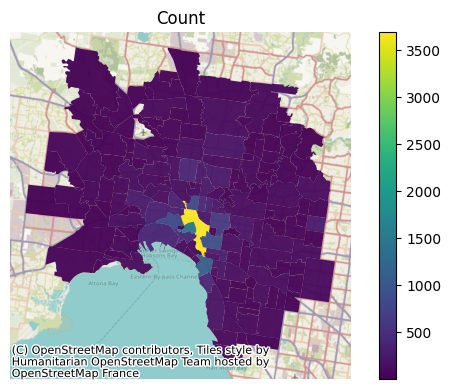

In [11]:
central_suburbs_web = central_suburbs_count.to_crs(epsg=3857)

fig, axs = plt.subplots(figsize=(6, 4))
central_suburbs_web.plot(ax=axs, column='Count', alpha=0.95, legend=True)
ctx.add_basemap(axs)
axs.set_title("Count")
axs.axis('off')
plt.tight_layout()

In [ ]:
# unique_listings_gdf = unique_listings_gdf[unique_listings_gdf['SAL_NAME21'].isin(central_suburbs['SAL_NAME21'].unique())]
# unique_listings = unique_listings_gdf.copy()
# del unique_listings['geometry']

## The prompt

In [27]:
prompt_explanatory = f"""
You are an expert in urban studies with a deep understanding of gentrification and its portrayal in public discourse. I will provide you with Airbnb 
listings, including a description of the property and a neighborhood overview. Your task is to analyze these texts and assess the gentrification status 
of the area based on how the neighborhood is presented.

Focus primarily on the neighborhood overview and description, ignoring property-specific details like the number of bedrooms, amenities, or decor. 

Consider the following:
- Direct mentions of local attractions, businesses, or community features that suggest development or revitalization.
- Language that highlights cultural hotspots, boutique shops, trendy cafes, or artisanal markets.
- Descriptions that emphasize diversity, safety, or the presence of creative communities, as these can signal gentrification dynamics.
- Listings that avoid mentioning the neighborhood or speak only broadly about the city may imply that the immediate area lacks desirable features or is 
not a selling point. This absence of detail should inform your assessment.

Assign one of the following categories:
- "Established": A well-known, desirable area with stable appeal and little active change.
- "Gentrifying": Signs of recent or ongoing transformation, such as new businesses or cultural shifts.
- "Emerging": Early indicators of gentrification potential, like creative spaces or gradual commercial interest.
- "Undeveloped": Lacking indicators of gentrification, often reflected in vague or absent neighborhood descriptions.

If a listing genuinely lacks sufficient information to make any assessment (e.g., the text is too sparse), assign a score of 'NA' and briefly explain.

Provide your answer strictly in the format:
'1. Category. Reasoning.', '2. Category. Reasoning.', etc., without any additional explanation or commentary.
"""
prompt = prompt_explanatory

## Decide whether to run LLM
Decide whether to run the LLM or load a file of scores that has been previously calculated and saved

In [28]:
# Check for existing files
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
base_filename = "airbnb_gentrification_scores_categorical_combined_listings_filtered"
file_extension = ".gpkg"

# List all matching files in the directory
matching_files = [
    f for f in sorted(os.listdir(base_dir))
    if re.match(f"{base_filename}_\\d{{2}}{file_extension}$", f)]
matching_files

[]

In [29]:
# If there are matching files, find the most recent one
if matching_files:
    df = gpd.read_file(base_dir+matching_files[-1])
    print(f"Loaded file: {matching_files[-1]}")
else:
    # If no matching files are found
    print("No matching files found. 'df' will not be loaded.")
    df = None

No matching files found. 'df' will not be loaded.


In [ ]:
RUN_LLM = True
if df is not None:
    print("Have already loaded a gentrification file, will not re-run the LLM.")
    RUN_LLM = False

RUN_LLM = True  # Optionally override

if RUN_LLM:
    print("Running LLM")
    # Get the API key from a file
    with open('../together.ai_key.txt', 'r') as f:
        api_key = f.readline().strip()

    client = Together(api_key=api_key)

    # Sample for now?
    # df = final_listings.sample(20).copy()
    df = deduplicated_listings.copy()

    print(f"Will query the LM for {len(df)} items")

    assert len(df) < 30000, "Too many tweets to process in one go. Please reduce the number of tweets."

    # Ensure the index is consecutive and ascending
    df = df.reset_index(drop=True)
    # To store the results
    df['gentrification_prediction'] = None

    # Batch processing
    batch_size = 20
    for i in range(0, len(df), batch_size):
        # Get the batch of tweets
        batch_tweets = df.loc[i:i + batch_size - 1, :]

        # Get sentiments using the function
        print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

        ids, sentiments, explanations = get_gentrification_scores_categorical(
            batch_tweets, prompt, client, batch_index=i, max_tokens=1500)
        # Update the DataFrame with the predictions
        df.loc[ids, 'gentrification_prediction'] = sentiments
        df.loc[ids, 'explanation'] = explanations

        # Predictions should be integers
        # df.gentrification_prediction = df.gentrification_prediction.astype('Int64')

    print("Finished querying LLM. Now saving file")

    # Initialize counter and check for existing files
    counter = 1
    while True:
        filename = f"{base_filename}_{counter:02d}.csv"
        filepath = os.path.join(base_dir, filename)
        if not os.path.exists(filepath):
            break
        counter += 1
    df.to_csv(f"{filepath}")    
    # df.set_crs(epsg=4326, inplace=True)
    # df.to_file(filepath, layer="data", driver="GPKG")
    print(f"File saved as: {filepath}")

Have already loaded a gentrification file, will not re-run the LLM.
Running LLM
Will query the LM for 19490 items
Submitting batch 1 of 974...
1. Gentrifying. The area is described as green, safe, and quiet, with easy access to the city center, suggesting a desirable and potentially gentrifying neighborhood.
1

2. Established. The listing highlights the area's trendy, modern, and central location, with a variety of shops, cafes, and entertainment options, indicating a well-established and desirable neighborhood.
2

3. Gentrifying. The description mentions the area's quiet, safe, and green environment, as well as its proximity to vibrant neighborhoods like Fitzroy and Richmond, suggesting a gentrifying dynamic.
3

4. Gentrifying. The listing emphasizes the area's eclectic character, with cafes, shops, and restaurants, as well as its proximity to the Yarra River and Abbotsford Convent, indicating a gentrifying neighborhood.
4

5. Established. The description highlights the area's inner-c